# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [The Business Problem](#problem)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results & Discussion](#results)
* [Conclusion](#conclusion)


## The Business Problem <a name="problem"></a>

**Introduction**

The goal of this project is to provide our business partners in Vienna with a clear empirical, visual and descriptive analysis of the best location to open their next Coffee Shop.


**Background**

Vienna, the capital city of Austria was recently classified again as the most liveable city in Europe ([link](https://tinyurl.com/sbzp86pv)). Among the important factors taken into account in this announcement, would be the broad spectrum of cultural and leisure activities. Coffee is one of these activities/passions that bring people together in this city. This is also one of the reasons that this destination has become the top choice of numerous investors for opening their Coffee Shop in.

## Data <a name="data"></a>

**Data Collection**

The data will be collected from different trusted sources that are released by the government to open public, from google API services, from open GitHub resources. For calibrating our geo-spatial locations with the EPSG dataset we will use the GeoRepository web services which adopt the latest ISO standards and is also open for public use. These resources will help us create our detailed dataframes and geo-dataframes which will include: a highly accurate mapping of the streets that would be of interest to us, the respective districts, the distances from the center and many more.


**Data Preparation**

All the dataframes will undergo to continuous appending and filtering processes. As we progress with our analysis, we will benefit from multiple visualizing tools that will help us create relations in and between different sets of data. Among these tools, we could list the variety of the folium’s tilesets including CircleMarkers, FastMarkerCluster, GeoJSON-TopoJSON Overlays as well as HeatMaps.

As we make progress in our research, by continuously refining our search parameters and filtering our list of results, we should be able to find our best candidates of places.

## Methodology <a name="methodology"></a>

This project followed a fixed strategical path. It began with the import of all the library of the tools that were used. After a careful territory analysis, it was concluded that the area of interest would include all the streets within a distance of *1.5 km* from the city center *Stephansdom* (St. Stephan's Cathedral).

The next step was to retrieve accurate and trusted data about the district divisions and street mapping. This helped in categorizing the streets that were investigated. To make this project safe of possible future changes of the online databases, a copy of [this](https://github.com/ginseng666/GeoJSON-TopoJSON-Austria/blob/master/2021/simplified-99.9/bezirke_999_geo.json) *GeoJSON* file with all the data about the district division was saved adjacent to the project notebook. In the street maps, a simplification method of the *Street Geometry* to *One Point Coordinate* was be applied. The advantages of this process, consisted that these street representing points had the additional function of acting as the centroids, from which the distance of the surrounding venues was measured. This provided a highly detailed density mapping of the venues across the total area of interest.

At this point on the project a connection to the Foursquare database was established and data for all the venues inside the area of interest was retrieved. This was then processed and visualized using tools that included **Folium** and **HeatMap**.

The analysis could finally begin after all the data was retrieved and prepared to meet the research standards. The functions *"coffees in vicinity", "closest coffee" and "distance from center"* that filtered 'the dataframe of results', so that from the total list of locations, only those meeting the three selecting criteria would be retrieved, were defined. The *candidates* dataframe containing the results of the filtering process was built by filtering out the locations with more than two coffee shops in vicinity.

After the values of the created dataframe were normalized, they could finally be ready to be processed by the **k-Means Clustering** machine learning model. To find the optimal number of clusters, the *Elbow method* was chosen. At this point the model was finally deployed and was able to provide four different clusters of place candidates. These were filtered one last time, so that in the end, only one area with the best among all candidates remained.

### Importing the necessary libraries 

In [1]:
import math # This module provides access to the mathematical functions defined by the C standard.
import pyproj # This is the cartographic projections and coordinate transformations library.
import folium # This module builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library.
import pickle # This module implements binary protocols for serializing and de-serializing a Python object structure.
import requests # This is an elegant and simple HTTP library for Python, built for human beings.
import numpy as np # This is a Python library that provides a simple yet powerful data structure: the n-dimensional array.
import pandas as pd # This is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool.
import geopandas as gpd #  This is an open source project to make working with geospatial data in python easier.
import matplotlib.cm as cm # This tool contains builtin colormaps and colormap handling utilities.
import matplotlib.colors as colors # This is a module for converting numbers or color arguments to RGB or RGBA.
import matplotlib.pyplot as plt # This is a collection of functions that makes matplotlib work like MATLAB.
from pandas import json_normalize # This tool normalizes semi-structured JSON data into a flat table.
from folium.plugins import HeatMap # This tool will help creating spatial visualizations.
from matplotlib.pyplot import figure # This tool helps creating and manipulating figures.
from geopy.geocoders import Nominatim # This is a geocoding tool that locates the coordinates of addresses.
from folium.plugins import FastMarkerCluster # This is a plugin that plots large numbers of markers efficiently.
from sklearn.cluster import KMeans # This is the method of vector quantization, that will partition the dataframe into k clusters.
from sklearn.datasets import make_blobs # This tool generates isotropic Gaussian blobs for clustering.
from sklearn.preprocessing import StandardScaler # This tools standardizes features by removing the mean and scaling to unit variance.
from mpl_toolkits.mplot3d import Axes3D # This tool will help creating 3D Axis for plotting.

After importing the libraries that will be used, the Project class should also be imported from the project_lib library of the IBM Cloud Pak for Data. A project object will then be created and initialized with the project ID and Access Token. This will be helful in storing and loading the databases from the cloud storage and in minimizing proccessing time of the project.

In the cell below, the Forsquare credentials will also be stored into the variables. These will be later used to retrieve the data of the venues of interest. Since these are sensitive data, they will be automatically hidden by Watson Studio.

In [2]:
# The code was removed by Watson Studio for sharing.

A variable for storing the center location of this research is created and initialized as below. The imported geolocator is then used to create a geocode object with the address as parameter. And the coordinates will be stored at same variable and therefore overwriting it, since only the Latitude and Longitude are needed in this case. 

In [3]:
address  = 'Stephansdom, Vienna'
geolocator = Nominatim(user_agent="http")
vienna_center = geolocator.geocode(address)
vienna_center = [vienna_center.latitude, vienna_center.longitude]
print('The geograpical coordinates of ',address, 'are', vienna_center)

The geograpical coordinates of  Stephansdom, Vienna are [48.2084923, 16.37312685415674]


With these coordinates as the center point, the area of interest will be set as the circle with radius of 1.5 km. And in the map it looks as follows:

In [4]:
map_area = folium.Map(location=vienna_center, zoom_start=14)

folium.Circle(
    radius=1500,
    location=vienna_center,
    popup="Area of interest",
    color="crimson",
    fill=False,
).add_to(map_area)

map_area

Since one of the criteria that will be worked upon is the calculation of the distance from the center point, it is useful save this location also as a geopandas 'geometry point'.

In [5]:
vienna_center_df = pd.DataFrame(
    {'City': ['Vienna'],
     'Country': ['Austria'],
     'Latitude': [vienna_center[0]],
     'Longitude': [vienna_center[1]]})

vienna_center_gdf = gpd.GeoDataFrame(vienna_center_df, geometry=gpd.points_from_xy(vienna_center_df.Longitude, vienna_center_df.Latitude))

The next step is to retrieve detailed information about the district division. This will help categorizing the streets that will be investigated. To make this project safe of possible future changes of the online databases, a copy of [this](https://github.com/ginseng666/GeoJSON-TopoJSON-Austria/blob/master/2021/simplified-99.9/bezirke_999_geo.json) GeoJSON file with all the data about the district division will be saved adjacent to this project notebook.

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
vienna_districts = districts_file
def districts_style(feature):
    return { 'color': 'purple', 'fill': False }

vienna_districts_df = gpd.read_file(vienna_districts)
vienna_districts_df = vienna_districts_df[vienna_districts_df["name"].str.contains("Wien ")].sort_values(by=['name'], ascending=True).reset_index()
# vienna_districts_df
map_vienna = folium.Map(location=vienna_center, zoom_start=13)
folium.GeoJson(vienna_districts_df, style_function=districts_style, name='geojson').add_to(map_vienna)
map_vienna

By combining the results of two plots... 

In [8]:
vienna_districts_gdf = vienna_districts_df.to_crs("EPSG:4326") 
districts_m = folium.Map(location=[vienna_center[0], vienna_center[1]],tiles="cartodbpositron", zoom_start=14)
folium.GeoJson(data=vienna_districts_gdf["geometry"][0:9]).add_to(districts_m) 
folium.Circle(radius=1500,location=vienna_center,popup="Area of interest",color="crimson",fill=False).add_to(districts_m)

districts_m

It is observed that the area of interest contains all the streets of the first district and in part those of the sorrounding districts. This is going to considerably reduce the size of the streets database in which it will be researched for potentially good locations.

As acted on the districts database, a copy of the [GeoJSON  Streets Databse](https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:STRASSENGRAPHOGD&srsName=EPSG:4326&outputFormat=json) provided by the Austrian Government as open data, will be saved adjacent to this notebook and loaded.

In [9]:
# The code was removed by Watson Studio for sharing.

In [10]:
vienna_streets = vienna_streets_file
def street_style(feature):
    return { 'color': 'green', 'fill': False }
vienna_streets_df = gpd.read_file(vienna_streets)

In [11]:
vienna_streets_df = vienna_streets_df[['BEZIRK','FEATURENAME','EDGECATEGORY_NAME','SHAPELENGTH','geometry']]
vienna_streets_df.rename(columns={'BEZIRK': 'District', 'FEATURENAME':'StreetName','EDGECATEGORY_NAME':'StreetType','SHAPELENGTH':'StreetLength','geometry':'Geometry'}, inplace=True)

After loading the dataframe, it is helpful to convert it to a GeoDataframe. This will make possible the use of already defined functions, such as 'distance'.

The loaded geodataframe has the following form... 

In [12]:
vienna_streets_df.head()

District         StreetName      StreetType  StreetLength  \
0  AT91701        Nesselgasse  Gemeindestraße    101.818937   
1  AT91301     Lainzer Straße  Gemeindestraße     91.229415   
2  AT91701  Klampfelberggasse  Gemeindestraße    161.468131   
3  AT91301      Björnsongasse  Gemeindestraße     36.658604   
4  AT90901   Simon-Denk-Gasse  Gemeindestraße    145.706272   

                                            Geometry  
0  MULTILINESTRING ((16.32210 48.22128, 16.32251 ...  
1  MULTILINESTRING ((16.28374 48.17674, 16.28331 ...  
2  MULTILINESTRING ((16.29199 48.23541, 16.29210 ...  
3  MULTILINESTRING ((16.29055 48.16367, 16.29063 ...  
4  MULTILINESTRING ((16.35968 48.22517, 16.35922 ...

However, since it's loaded direclty from the official source, it still needs to be filtered so that it contains only the streets of interest.

In [13]:
print('The Vienna Streets dataframe contains {} districts and {} streets.'.format(
        len(vienna_streets_df['District'].unique()),
        vienna_streets_df.shape[0]
    )
)

The Vienna Streets dataframe contains 24 districts and 28483 streets.


The filtering is done by creating and storing streets data as follows:

In [14]:
dist_km = 1.5
district = []
streets_of_interest = []
streets_geometry = []
distance_from_center = []

for index, row in vienna_streets_df.iterrows():
    if ((vienna_center_gdf['geometry'][0].distance(row['Geometry'])*100) < dist_km):
        district.append(row['District'])
        streets_of_interest.append(row['StreetName'])
        streets_geometry.append(row['Geometry'])
        distance_from_center.append(vienna_center_gdf['geometry'][0].distance(row['Geometry'])*100)
        
print ("Now the dataframe with streets of interest will contain",len(streets_of_interest),"streets.")

Now the dataframe with streets of interest will contain 1461 streets.


A preview of this streets_of_interest array looks as follows:

In [15]:
streets_of_interest [24:30]

['Kleine Pfarrgasse',
 'Hahngasse',
 'Beatrixgasse',
 'Franz-Josefs-Kai',
 'Matthäusgasse',
 'Große Schiffgasse']

The filtered arrays can now be united to single geodataframe...

In [16]:
streets_of_interest_df = gpd.GeoDataFrame({
                                        'District': district,
                                        'Street': streets_of_interest,
                                        'Distance from Center': distance_from_center,
                                        'Geometry': streets_geometry})

This dataframe now contains all the details needed for the purpose of this research...

In [17]:
streets_of_interest_df.head(5)

District             Street  Distance from Center  \
0  AT90101  Rosenbursenstraße              0.694302   
1  AT90101           Burgring              1.028146   
2  AT90101      Schulerstraße              0.111472   
3  AT90101      Getreidemarkt              0.995658   
4  AT90201      Leopoldsgasse              1.216450   

                                            Geometry  
0  (LINESTRING (16.37996772360402 48.209678897641...  
1  (LINESTRING (16.36420931166845 48.203375080457...  
2  (LINESTRING (16.3742389292431 48.2085690122749...  
3  (LINESTRING (16.36685224292623 48.200761660958...  
4  (LINESTRING (16.37578504156131 48.220545899319...

In [18]:
print('The Vienna Streets of Interest dataframe contains {} districts and {} streets.'.format(
        len(streets_of_interest_df['District'].unique()),
        streets_of_interest_df.shape[0]
    )
)

The Vienna Streets of Interest dataframe contains 7 districts and 1461 streets.


In [19]:
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90101'),'District']='Wien 1.,Innere Stadt'
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90201'),'District']='Wien 2.,Leopoldstadt'
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90301'),'District']='Wien 3.,Landstraße'
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90401'),'District']='Wien 4.,Wieden'
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90601'),'District']='Wien 6.,Mariahilf'
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90701'),'District']='Wien 7.,Neubau'
streets_of_interest_df.loc[(streets_of_interest_df.District == 'AT90901'),'District']='Wien 9.,Alsergrund'

After renaming the columns with clear titles, this dataframe can be grouped by number of streets in every district as follows: 

In [20]:
streets_of_interest_df.groupby('District').count()

Street  Distance from Center  Geometry
District                                                    
Wien 1.,Innere Stadt     827                   827       827
Wien 2.,Leopoldstadt     251                   251       251
Wien 3.,Landstraße       177                   177       177
Wien 4.,Wieden           111                   111       111
Wien 6.,Mariahilf         26                    26        26
Wien 7.,Neubau             1                     1         1
Wien 9.,Alsergrund        68                    68        68

By observing the resulting table and large proportion of around **57%** of the streets being located in the **first district**, an assumption that the best area of interest lies also in this district. Let's investigate further...

At this part of the project, the method that simplifies the **Street Geometry** to one **Point Coordinates** will be applied. The advantages of this process, consist that these ***street representing points*** have the additional function of acting as the **centroids**, from which the distance of the surrounding venues will be measured. This should provide a highly detailed ***density mapping*** of the venues across the total area of interest.

An example of this process would look like this:

In [21]:
streets_of_interest_df.loc[0, 'Street']

street_geometry = streets_of_interest_df.loc[0, 'Geometry'] # street latitude value

street_name = streets_of_interest_df.loc[0, 'Street'] # street name

print('The street\'s "{}" representative point coordinate is {}.'.format(street_name,street_geometry[0].centroid))

The street's "Rosenbursenstraße" representative point coordinate is POINT (16.38055813769048 48.20947431974476).


To apply this to the streets dataframe as a whole, the data is retrieved through the **centroid** function from the geopandas library and then stored to the respective Latitude and Longitude arrays.

In [22]:
latitudes = []
longitudes = []

for index, row in streets_of_interest_df.iterrows():
    longitudes.append(row['Geometry'][0].centroid.x)
    latitudes.append(row['Geometry'][0].centroid.y)

Two new columns are then initialized with data of the arrays and then appended to the main *streets of interest dataframe*.

In [23]:
streets_of_interest_df['Latitude'] = latitudes
streets_of_interest_df['Longitude'] = longitudes

Finally, the *streets of interest dataframe* contains exactly all the crucial elements that will be needed on this research.

In [24]:
streets_of_interest_df.head(10)

District              Street  Distance from Center  \
0  Wien 1.,Innere Stadt   Rosenbursenstraße              0.694302   
1  Wien 1.,Innere Stadt            Burgring              1.028146   
2  Wien 1.,Innere Stadt       Schulerstraße              0.111472   
3  Wien 1.,Innere Stadt       Getreidemarkt              0.995658   
4  Wien 2.,Leopoldstadt       Leopoldsgasse              1.216450   
5  Wien 2.,Leopoldstadt     Schiffamtsgasse              1.035552   
6  Wien 1.,Innere Stadt   Grillparzerstraße              1.487551   
7  Wien 2.,Leopoldstadt  Schrottgießergasse              1.250114   
8  Wien 1.,Innere Stadt        Zedlitzgasse              0.597031   
9  Wien 1.,Innere Stadt        Plankengasse              0.367890   

                                            Geometry   Latitude  Longitude  
0  (LINESTRING (16.37996772360402 48.209678897641...  48.209474  16.380558  
1  (LINESTRING (16.36420931166845 48.203375080457...  48.203584  16.363848  
2  (LINESTRING (16.3742389292431 48.2085690122749...  48.208498  16.374513  
3  (LINESTRING (16.36685224292623 48.200761660958...  48.200757  16.366289  
4  (LINESTRING (16.37578504156131 48.220545899319...  48.220404  16.375994  
5  (LINESTRING (16.37359355911734 48.218837293660...  48.218879  16.373982  
6  (LINESTRING (16.35878884960779 48.212454932501...  48.212520  16.358312  
7  (LINESTRING (16.38349182496682 48.215481284515...  48.215276  16.383785  
8  (LINESTRING (16.37886775371865 48.206853192396...  48.206650  16.379305  
9  (LINESTRING (16.37014275676101 48.206340680525...  48.206446  16.369875

The visualizing of the dataframe can now take place...

In [25]:
map_streets = folium.Map(location=vienna_center, zoom_start=15)

# add markers to map
for lat, long, district, street in zip(streets_of_interest_df['Latitude'], streets_of_interest_df['Longitude'], streets_of_interest_df['District'], streets_of_interest_df['Street']):
    label = '{}, {}'.format(street, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_streets)  
    
map_streets

Now the process of retrieving venues nearby the centroids that were created can begin. To achieve this, a connection to the Forsquare database through the Developer API will be established. The first step is creating a function that will have as input parameters a **searching radius**, the **street name** and the **latitude** & **longitude** values. The function will firstly make an API request to the Forsquare server, then make a a GET request, append the retrieve data to an array and finally create & initialize a dataframe with the complete array.

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
            
        # Make an API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        
        # Make a GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        # Append data to array
        venues_list.append([(name, lat, lon, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lon'],  v['venue']['categories'][0]['name']) for v in results])
    
    # Create and initialize dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 'Street Latitude', 'Street Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

From trial and error it was learned that the function takes a considerable ammount of time to retrieve all the venues and sometimes gets interrupted. To solve this, after successfully retrieving all the venues of interest and stored to a dataframe, a copy was saved adjacent to this notebook file. This will be available along with all the other files on the github repository of this project.

In [27]:
# We will try to load all the venues from the vienna_venues file that would have been generated if the Notebook was executed at least once.
vienna_venues = {}
loaded = False
try:
    # Download and load dataframe from storage
    vienna_venues = pickle.load(project.get_file('vienna_venues.pkl'))
    loaded = True
except:
    print("The venues could not be loaded to dataframe, they will be retrieved now...")
    pass

# If the Notebook is runinng for the first time, the venues data will be retrieved from Forsquare and saved locally
if not loaded:
    vienna_venues = getNearbyVenues(names=streets_of_interest_df['Street'],
                                   latitudes=streets_of_interest_df['Latitude'],
                                   longitudes=streets_of_interest_df['Longitude']
                                  )   
    # Save dataframe as pickle file to storage
    project.save_data(data=pickle.dumps(vienna_venues),file_name='vienna_venues.pkl',overwrite=True)

After being retrieved the dataframe is constructed as follows:

In [28]:
vienna_venues.head()

Street  Street Latitude  Street Longitude  \
0  Rosenbursenstraße        48.209474         16.380558   
1  Rosenbursenstraße        48.209474         16.380558   
2  Rosenbursenstraße        48.209474         16.380558   
3  Rosenbursenstraße        48.209474         16.380558   
4  Rosenbursenstraße        48.209474         16.380558   

                                               Venue  Venue Latitude  \
0                                               Yori       48.210865   
1                                      Marco Simonis       48.209139   
2  MAK - Österreichisches Museum für angewandte K...       48.207650   
3                                       Salad Jungle       48.209242   
4                                Konstantin Filippou       48.210643   

   Venue Longitude     Venue Category  
0        16.381681  Korean Restaurant  
1        16.379909               Café  
2        16.381390         Art Museum  
3        16.381018        Salad Place  
4        16.379759         Restaurant

In [29]:
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 201 uniques categories.


By taking a closer look at the online Forsquare categories it is learned that the names of the categories Café and Coffee Shop are consistently used interchangeably. For this reason both the categories will be selected and analyzed. 

In [30]:
cafe_df = vienna_venues[vienna_venues['Venue Category'].isin(['Café'])].reset_index(drop=True)
cafe_df.head(10)

Street  Street Latitude  Street Longitude  \
0  Rosenbursenstraße        48.209474         16.380558   
1  Rosenbursenstraße        48.209474         16.380558   
2  Rosenbursenstraße        48.209474         16.380558   
3  Rosenbursenstraße        48.209474         16.380558   
4  Rosenbursenstraße        48.209474         16.380558   
5  Rosenbursenstraße        48.209474         16.380558   
6           Burgring        48.203584         16.363848   
7           Burgring        48.203584         16.363848   
8           Burgring        48.203584         16.363848   
9           Burgring        48.203584         16.363848   

                               Venue  Venue Latitude  Venue Longitude  \
0                      Marco Simonis       48.209139        16.379909   
1                        Café Diglas       48.210777        16.376921   
2                    Kaffee Alt Wien       48.209147        16.376177   
3                     Cafe Engländer       48.208019        16.378555   
4                  Café Daniel Moser       48.210523        16.374818   
5                       Café Prückel       48.207481        16.380053   
6                               phil       48.200196        16.361219   
7  Gerstner K. u. K. Hofzuckerbäcker       48.203163        16.370269   
8                            MQdaily       48.203309        16.358773   
9           Café-Restaurant Bellaria       48.206046        16.359109   

  Venue Category  
0           Café  
1           Café  
2           Café  
3           Café  
4           Café  
5           Café  
6           Café  
7           Café  
8           Café  
9           Café

In [31]:
coffee_shop_df = vienna_venues[vienna_venues['Venue Category'].isin(['Coffee Shop'])].reset_index(drop=True)
coffee_shop_df.head()

Street  Street Latitude  Street Longitude                Venue  \
0  Rosenbursenstraße        48.209474         16.380558         Fenster Cafe   
1  Rosenbursenstraße        48.209474         16.380558            Starbucks   
2  Rosenbursenstraße        48.209474         16.380558   Coffeeshop Company   
3           Burgring        48.203584         16.363848  Akrap Finest Coffee   
4      Schulerstraße        48.208498         16.374513         Fenster Cafe   

   Venue Latitude  Venue Longitude Venue Category  
0       48.210727        16.377217    Coffee Shop  
1       48.211478        16.375927    Coffee Shop  
2       48.207549        16.379432    Coffee Shop  
3       48.200503        16.360052    Coffee Shop  
4       48.210727        16.377217    Coffee Shop

Now the dataframes can be concatenated into one as follows:

In [32]:
coffee_df = pd.concat([cafe_df, coffee_shop_df]).sort_values(by=['Street']).reset_index(drop=True)
coffee_df.head(10)

Street  Street Latitude  Street Longitude  \
0  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
1  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
2  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
3  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
4  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
5  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
6  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
7  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
8  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   
9  Abraham-a-Sancta-Clara-Gasse        48.209933         16.363043   

                         Venue  Venue Latitude  Venue Longitude Venue Category  
0                  Café Am Hof       48.210480        16.367851           Café  
1                        Sluka       48.209462        16.357965           Café  
2  Unger und Klein im Hochhaus       48.209460        16.366039           Café  
3                 Café Central       48.210348        16.365391           Café  
4               Café Landtmann       48.211652        16.361087           Café  
5                    Starbucks       48.213258        16.363041    Coffee Shop  
6                  Kaffeeküche       48.214016        16.361921    Coffee Shop  
7        Landtmann's Bel-Etage       48.211654        16.361176           Café  
8      CaffèCouture District 1       48.211394        16.365712    Coffee Shop  
9                    Stadtcafe       48.211436        16.366013           Café

Now if grouped by the streets, the following results can be obtained...

In [33]:
coffee_df.groupby('Street').count()

Street Latitude  Street Longitude  Venue  \
Street                                                                   
Abraham-a-Sancta-Clara-Gasse               10                10     10   
Adambergergasse                             6                 6      6   
Akademiestraße                             29                29     29   
Albertinaplatz                             17                17     17   
Alexander-Poch-Platz                        9                 9      9   
...                                       ...               ...    ...   
Zirkusgasse                                30                30     30   
Zollamtssteg                                5                 5      5   
Zollgasse                                   2                 2      2   
Äußeres Burgtor                             6                 6      6   
Ölzeltgasse                                 7                 7      7   

                              Venue Latitude  Venue Longitude  Venue Category  
Street                                                                         
Abraham-a-Sancta-Clara-Gasse              10               10              10  
Adambergergasse                            6                6               6  
Akademiestraße                            29               29              29  
Albertinaplatz                            17               17              17  
Alexander-Poch-Platz                       9                9               9  
...                                      ...              ...             ...  
Zirkusgasse                               30               30              30  
Zollamtssteg                               5                5               5  
Zollgasse                                  2                2               2  
Äußeres Burgtor                            6                6               6  
Ölzeltgasse                                7                7               7  

[493 rows x 6 columns]

In [34]:
print('Total number of Venues:', len(vienna_venues))
print('Total number of Cafés:', len(coffee_df))
print('Percentage of Cafés: {:.2f}%'.format(len(coffee_df) / len(vienna_venues) * 100))
print('Average number of Cafés in a street:', coffee_df.groupby(by=["Street"]).count().mean()[0])

Total number of Venues: 104130
Total number of Cafés: 9361
Percentage of Cafés: 8.99%
Average number of Cafés in a street: 18.98782961460446


In [35]:
map_cafes = folium.Map(location = vienna_center, zoom_start = 14)

folium.Marker(vienna_center, popup = 'Stephansdom').add_to(map_cafes)
map_cafes.add_child(FastMarkerCluster(coffee_df[['Venue Latitude', 'Venue Longitude']]))
map_cafes.save("map_cafes.html")
map_cafes

As it can be seen on the map, there is a very high concentration of Coffee Shops in the area of Schwedenplatz and it looks rather difficult finding a good location spot that will meet the requirements.

In [36]:
map_cafes_h = folium.Map(location=vienna_center, zoom_start=14)
folium.GeoJson(data=vienna_districts_gdf["geometry"][0:9], style_function=districts_style, name='geojson').add_to(map_cafes_h) 
folium.Circle(radius=1800,location=vienna_center,popup="Area of interest",color="white",fill=False).add_to(map_cafes_h)
folium.Marker(vienna_center, popup = 'Stephansdom').add_to(map_cafes_h)
map_cafes_h.add_child(FastMarkerCluster(coffee_df[['Venue Latitude', 'Venue Longitude']]))
map_cafes_h.add_child(HeatMap(coffee_df[['Venue Latitude', 'Venue Longitude']], radius = 40))
map_cafes_h.save("map_cafes_h.html")
map_cafes_h

At the first sight, it might seem that in the direction south-west from the city center, there might be a small pocket that could be an area of interest.

## Analysis <a name="analysis"></a>

### Finding the best spot for the coffee shop

Until this point, it is found that...

In [37]:
print('... there are ',streets_of_interest_df.shape[0], 'streets in total, inside the area of interest.')

... there are  1461 streets in total, inside the area of interest.


It was also concluded that all the Cafés in this area are located... 

In [38]:
print('... in ',len(coffee_df.groupby('Street').count()), 'streets.')



... in  493 streets.


Another attempt of filtering for good locations with **simple tools** (opposed to building a Machine Learning Model and Clustering the dataframe) is made. In this attempt, it will be investigated whether all the streets of the **big** streets of interest dataframe have a coffe shop from the **small** coffee dataframe.

In [39]:
small = coffee_df['Street'].drop_duplicates().reset_index(drop=True).tolist()
big = streets_of_interest_df['Street'].drop_duplicates().reset_index(drop=True).tolist()
all(elem in big for elem in small)

True

...and now let's see which streets do not have any coffee shops:

In [40]:
np.setdiff1d(big,small)

array(['Kolonitzgasse', 'Zwerggasse'], dtype='<U34')

These partial results are however very minimalistic in information, since a street not containing a coffee shop is not necessarily the ***only*** good factor to be taken into account.

For the clear advantages mentioned previously, the coffe dataframe is converted to a geodataframe as follows:

In [41]:
coffee_gdf = gpd.GeoDataFrame(
    coffee_df, geometry=gpd.points_from_xy(coffee_df['Venue Longitude'], coffee_df['Venue Latitude'] ))

At this point, the functions which will filter ***the dataframe of results*** so that from the total list of locations, only those meeting the three selecting criteria will be retrieved, are defined.

In [42]:
def coffees_in_vicinity (street_point,coffee_gdf,radius):
    count = 0
    for coffee_point in coffee_gdf['geometry']:
        if (street_point.distance(coffee_point)*100000 <radius):
            count+=1
    return count

def closest_coffee (point, coffee_gdf):
    d_min = 2000
    for coffee in coffee_gdf['geometry']:
        dist = coffee.distance(point)*100000
        if dist<d_min:
            d_min = dist
    return d_min

def distance_from_center (point):
    for coffee in coffee_gdf['geometry']:
        dist = coffee.distance(vienna_center_gdf['geometry'][0])*100000
    return dist

Like previously acted with a dataframe that requires a considerable amount of time to process, this dataframe will be loaded with all the results from the result_df file that would have been generated if the Notebook was executed at least once. If not, by using the function defined in the cell above, the dataframe containing the results of the analysis will be built as follows:


In [43]:
result_df = {}
loaded = False
try:
    result_df = pickle.load(project.get_file('result_df.pkl'))    
    print('Result Dataframe loaded.')
    loaded = True
except:
    print("The Results could not be loaded to dataframe, they will be retrieved now...")
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    # Search Parameter
    radius = 250 
    nr_close_coffees = []
    dist_closest_coffee = []
    dist_from_center = []

    for street in streets_of_interest_df['Geometry']:
        amount = coffees_in_vicinity(street,coffee_gdf,radius)
        nr_close_coffees.append(amount)
        distance = closest_coffee(street, coffee_gdf)
        dist_closest_coffee.append(float("{:.2f}".format(distance)))        
        dist_from_center.append(float("{:.2f}".format(street.distance(vienna_center_gdf['geometry'][0])*100000)))
    
    result_df =pd.DataFrame({'Street Name of the Location':streets_of_interest_df['Street'],                         
                         'Closest Café distance (m)':dist_closest_coffee,
                         'Number of close Cafés':nr_close_coffees,
                         'Distance from Center (m)':dist_from_center,
                         'Latitude':streets_of_interest_df['Latitude'],
                         'Longitude':streets_of_interest_df['Longitude'],
                        })
    # Save dataframe as pickle file to storage
    project.save_data(data=pickle.dumps(result_df),file_name='result_df.pkl',overwrite=True)

Result Dataframe loaded.


In [44]:
result_df.head(10)

Street Name of the Location  Closest Café distance (m)  \
0           Rosenbursenstraße                      52.98   
1                    Burgring                      64.43   
2               Schulerstraße                     156.98   
3               Getreidemarkt                      97.79   
4               Leopoldsgasse                     243.08   
5             Schiffamtsgasse                     308.67   
6           Grillparzerstraße                     154.31   
7          Schrottgießergasse                       2.80   
8                Zedlitzgasse                      86.88   
9                Plankengasse                      45.09   

   Number of close Cafés  Distance from Center (m)   Latitude  Longitude  
0                    694                    694.30  48.209474  16.380558  
1                     69                   1028.15  48.203584  16.363848  
2                    898                    111.47  48.208498  16.374513  
3                    386                    995.66  48.200757  16.366289  
4                    150                   1216.45  48.220404  16.375994  
5                      0                   1035.55  48.218879  16.373982  
6                    202                   1487.55  48.212520  16.358312  
7                    218                   1250.11  48.215276  16.383785  
8                    456                    597.03  48.206650  16.379305  
9                     81                    367.89  48.206446  16.369875

In [45]:
result_df['Street Name of the Location'].unique()

array(['Rosenbursenstraße', 'Burgring', 'Schulerstraße', 'Getreidemarkt',
       'Leopoldsgasse', 'Schiffamtsgasse', 'Grillparzerstraße',
       'Schrottgießergasse', 'Zedlitzgasse', 'Plankengasse',
       'Weintraubengasse', 'Schottengasse', 'Hafnergasse', 'Schmelzgasse',
       'Renngasse', 'Rosengasse', 'Oppolzergasse', 'Wiedner Hauptstraße',
       'Stubenbastei', 'Eßlinggasse', 'Ruprechtsplatz',
       'Josef-Meinrad-Platz', 'Deutschmeisterplatz', 'Strohgasse',
       'Kleine Pfarrgasse', 'Hahngasse', 'Beatrixgasse',
       'Franz-Josefs-Kai', 'Matthäusgasse', 'Große Schiffgasse',
       'Theodor-Herzl-Stiege', 'Seilerstätte', 'Karlsplatz',
       'Mattiellistraße', 'Technikerstraße', 'Sparefrohgasse',
       'Fischerstiege', 'Am Hof', 'Berggasse', 'Dorotheergasse',
       'Favoritenstraße', 'Gußhausstraße', 'Dominikanerbastei',
       'Türkenstraße', 'Lagergasse', 'Weihburggasse', 'Wasagasse',
       'Universitätsstraße', 'Markthallenbrücke', 'Postgasse',
       'Elisabethstraße'

Now the results can be further filtered, so that a **better candidates list** of locations does not have more than **two** close-by coffee shops.

In [46]:
cafes_nearby = 2
print ('There are',(result_df['Number of close Cafés']<=cafes_nearby).sum(),'locations with',cafes_nearby,'or less Cafés nearby.')

There are 184 locations with 2 or less Cafés nearby.


In [47]:
candidates_df = result_df[result_df['Number of close Cafés']<=cafes_nearby].reset_index(drop=True)
candidates_df.head()

Street Name of the Location  Closest Café distance (m)  \
0             Schiffamtsgasse                     308.67   
1                  Strohgasse                     328.45   
2                  Strohgasse                     313.46   
3          Untere Donaustraße                     252.65   
4            Lothringerstraße                     261.89   

   Number of close Cafés  Distance from Center (m)   Latitude  Longitude  
0                      0                   1035.55  48.218879  16.373982  
1                      0                   1191.14  48.198125  16.379337  
2                      0                   1264.08  48.198174  16.380756  
3                      0                   1473.16  48.213623  16.387263  
4                      0                    847.65  48.200688  16.376634

The candidates dataframe can now be converted to a geodataframe and completed with the additional geometry points column as follows:

In [48]:
candidates_gdf = gpd.GeoDataFrame(
    candidates_df, geometry=gpd.points_from_xy(candidates_df['Longitude'], candidates_df['Latitude'] ))
candidates_gdf.head()

Street Name of the Location  Closest Café distance (m)  \
0             Schiffamtsgasse                     308.67   
1                  Strohgasse                     328.45   
2                  Strohgasse                     313.46   
3          Untere Donaustraße                     252.65   
4            Lothringerstraße                     261.89   

   Number of close Cafés  Distance from Center (m)   Latitude  Longitude  \
0                      0                   1035.55  48.218879  16.373982   
1                      0                   1191.14  48.198125  16.379337   
2                      0                   1264.08  48.198174  16.380756   
3                      0                   1473.16  48.213623  16.387263   
4                      0                    847.65  48.200688  16.376634   

                    geometry  
0  POINT (16.37398 48.21888)  
1  POINT (16.37934 48.19812)  
2  POINT (16.38076 48.19817)  
3  POINT (16.38726 48.21362)  
4  POINT (16.37663 48.20069)

As previously noticed, the area near street **Reitschulgasse** contains a few good candidates. For this reason the street is set as a center point and marked on the map. This will be later checked, wether or not being considered among the top candidates by the machine learning model.

In [49]:
candidate_address = geolocator.geocode('Reitschulgasse, Vienna')
candidate_address_coord = [candidate_address.latitude, candidate_address.longitude]

In [50]:
candidates_map = folium.Map(location = candidate_address_coord, zoom_start = 15)
folium.Circle(radius=200,location=candidate_address_coord,popup="Area of interest",color="crimson",fill=False).add_to(candidates_map)
folium.Marker(vienna_center, popup = 'Stephansdom').add_to(candidates_map)
candidates_map.add_child(FastMarkerCluster(candidates_gdf[['Latitude', 'Longitude']]))
candidates_map

In [51]:
candidates_gdf.head()

Street Name of the Location  Closest Café distance (m)  \
0             Schiffamtsgasse                     308.67   
1                  Strohgasse                     328.45   
2                  Strohgasse                     313.46   
3          Untere Donaustraße                     252.65   
4            Lothringerstraße                     261.89   

   Number of close Cafés  Distance from Center (m)   Latitude  Longitude  \
0                      0                   1035.55  48.218879  16.373982   
1                      0                   1191.14  48.198125  16.379337   
2                      0                   1264.08  48.198174  16.380756   
3                      0                   1473.16  48.213623  16.387263   
4                      0                    847.65  48.200688  16.376634   

                    geometry  
0  POINT (16.37398 48.21888)  
1  POINT (16.37934 48.19812)  
2  POINT (16.38076 48.19817)  
3  POINT (16.38726 48.21362)  
4  POINT (16.37663 48.20069)

Now that the dataframe containing the top candindates of places is created and filtered, it can be proceeded with the next step of this data science project.

## Building and deploying the Machine Learning model

The data in which it is going to be investigated upon, conains valuable information of the three main selection criteria (*Closest Café distance*,*Number of close Cafés*,*Distance from Center*), however it is ***unlabeled*** and the best results can be found by ***segmenting*** it. One of the best machine learning models for this type problem, would be the *unsupersived learning approach* of **k-Means Clustering**.

The first step to be taken at this point, is the preparation of the data for the model. To prevent possible unwanted modifications of the candidates geodataframe, a copy is created as follows:

In [52]:
copy_df = candidates_gdf[["Closest Café distance (m)","Number of close Cafés","Distance from Center (m)"]]
df = copy_df.copy()

Now that values of the columns of interest (*Closest Café distance*,*Number of close Cafés*,*Distance from Center*) can be retrieved for further processing. An important factor that should not be neglected is the ***normalization*** of the values. This will guarantee that the results of this analysis will not be affected by the relative major differences in value between the different columns (*e.g. the number close coffee shops was set to range between 0 and 2, on the other hand the distance from the city center can have a range of up to 1500 (meters)*).

In [53]:
X = df.values[:,0:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

As a possible disadvantage of the k-Means Clustering, could be considered the manual decision of the cluster number. However this is going to prevented by making use of the **Elbow Method**. This method returns the optimal number of clusters for any given dataset. To the dataframe that is being worked on this part of the project, the method could be applied as follows:

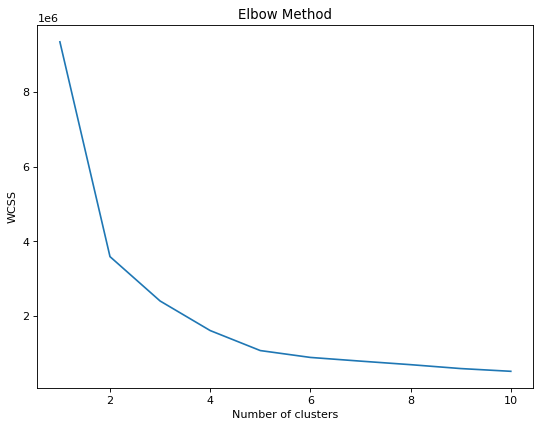

In [54]:
%matplotlib inline

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Now the number of clusters can be set equal to four, the *elbow point* of the curve. At this point, the data can be considered *ready* to be fitted model. As a result, the model should return the **Cluster Labels**.

In [55]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[2 2 1 1 0 0 3 0 2 0 0 0 2 1 1 1 0 2 2 2 3 0 2 0 2 2 1 0 2 1 0 1 0 2 1 2 0
 1 1 2 1 1 2 3 2 1 1 2 2 1 1 0 2 1 1 1 2 2 2 3 2 3 0 2 1 1 3 1 1 1 0 2 1 3
 3 2 1 1 2 0 3 2 2 0 3 1 0 1 1 2 0 1 1 2 2 1 2 1 2 2 0 3 2 1 1 3 1 3 3 2 1
 0 1 1 3 2 3 1 1 1 2 0 2 2 0 1 2 1 1 1 1 1 1 1 0 1 2 1 1 0 1 0 2 0 1 2 2 1
 2 0 1 0 0 0 2 1 3 2 0 1 2 1 1 3 1 0 2 2 0 0 0 0 0 3 0 1 2 2 1 2 2 2 2 0]


Now the structure **clustered dataframe** would looks as follows:

In [56]:
df["Cluster"] = labels
df.groupby('Cluster').mean()

Closest Café distance (m)  Number of close Cafés  \
Cluster                                                     
0                       291.240976                      0   
1                       316.255455                      0   
2                       344.322931                      0   
3                       564.770526                      0   

         Distance from Center (m)  
Cluster                            
0                      893.021707  
1                     1388.904697  
2                     1122.966034  
3                     1281.607368

To provide a better view of how the list of candidates is distributed, the generated dataframe can be plotted as follows:

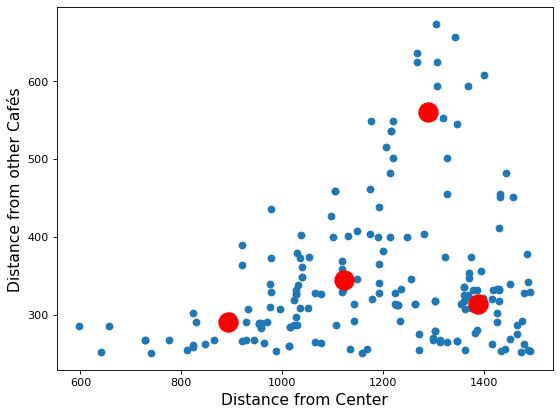

In [57]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,2], X[:,0])
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s=300, c='red')
plt.ylabel('Distance from other Cafés', fontsize=14)
plt.xlabel('Distance from Center', fontsize=14)
plt.show()

Although the number of Cafés was set a minimum, it will be considered in plotting the next figure for the purpose of detecting of possible outliers...

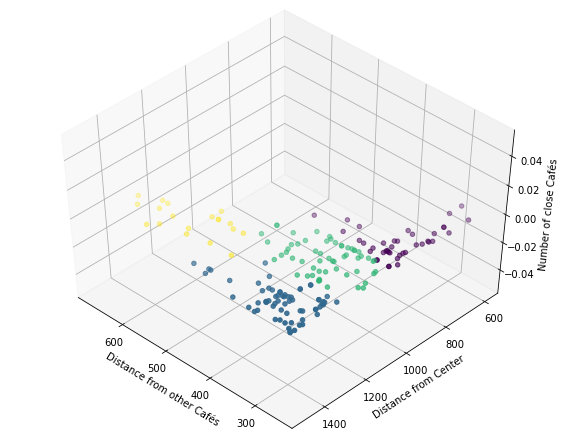

In [58]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('Distance from other Cafés')
ax.set_ylabel('Distance from Center')
ax.set_zlabel('Number of close Cafés')

ax.scatter(X[:, 0], X[:, 2], X[:, 1], c= labels.astype(np.float))

In a clustered two dimensional scatter plot final dataframe of top candidate locations looks as follows:

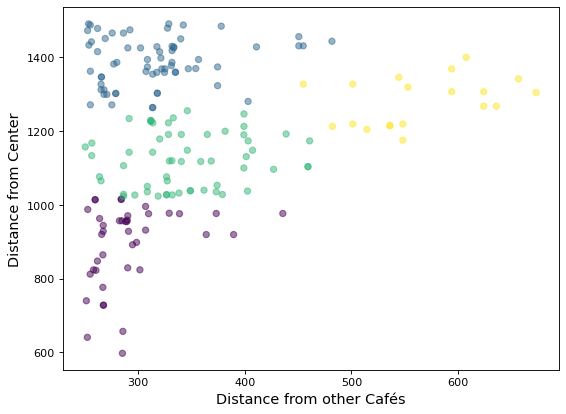

In [59]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
area = np.pi * ( X[:, 1]+1)**2
plt.scatter(X[:, 0], X[:, 2], s=10*area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Distance from other Cafés', fontsize=13)
plt.ylabel('Distance from Center', fontsize=13)
plt.show()

As it can be noticed in the plot, the yellow cluster contains locations that are at a relatively small distance from the city center and at the same time, the distance from other Cafés considerably higher for this cluster. By investigeating the results closer, the street **Förstergasse** could be set as center point of this cluster.

In [60]:
cluster_center = geolocator.geocode("Förstergasse, Vienna")
cluster_center_coord = [cluster_center.latitude, cluster_center.longitude]

An updated map that presents these findins can now be plotted... 

In [61]:
map = folium.Map(location = [48.214979, 16.370825], zoom_start = 15)

folium.Circle(radius=200,location=candidate_address_coord,color="crimson",fill=True, fill_opacity=0.05).add_to(map)
folium.Marker(candidate_address_coord, popup = 'Area of interest').add_to(map)

folium.Circle(radius=300,location=cluster_center_coord,color="green",fill=True, fill_opacity=0.05).add_to(map)
folium.Marker(cluster_center_coord, popup = 'Better area of interest').add_to(map)

folium.Marker(vienna_center, popup = 'Stephansdom').add_to(map)
map.add_child(FastMarkerCluster(candidates_gdf[['Latitude', 'Longitude']]))
map

As shown in the map, the first assumption (*the area marked with the red circle*) is not considered as the best location. The best area to be considered for potential coffe shop locations is located in the North direction (*marked with the green circle*) of the city center. The street **Zwerggasse** that was filtered earlier in the project, is also part of this cluster.

The top candidate locations can now be selected from this cluster as follows:

In [62]:
df = result_df.loc[(result_df['Distance from Center (m)'] >= 1150) 
                & (result_df['Distance from Center (m)'] <= 1350)
                & (result_df['Closest Café distance (m)'] > 500)].drop_duplicates(subset=['Street Name of the Location']).reset_index(drop=True)
df

Street Name of the Location  Closest Café distance (m)  \
0           Obere Donaustraße                     536.08   
1       Untere Augartenstraße                     548.30   
2                 Krafftgasse                     544.48   
3             Rembrandtstraße                     536.14   
4                Förstergasse                     635.91   
5                   Haasgasse                     594.02   
6                  Zwerggasse                     624.06   
7              Roßauer Brücke                     514.69   

   Number of close Cafés  Distance from Center (m)   Latitude  Longitude  
0                      0                   1215.20  48.220666  16.369586  
1                      0                   1175.60  48.220441  16.372384  
2                      0                   1346.30  48.222064  16.373414  
3                      0                   1215.20  48.220792  16.370576  
4                      0                   1267.87  48.221267  16.371630  
5                      0                   1307.16  48.221864  16.372812  
6                      0                   1307.16  48.221699  16.372153  
7                      0                   1204.89  48.220063  16.369592

These can be now finally plotted on the map

In [63]:
df['combine']= df[['Latitude', 'Longitude']].values.tolist()

map = folium.Map(location = cluster_center_coord, zoom_start = 17)
for point in range(0, len(df["combine"])):
    folium.Marker(df["combine"][point], popup=df['Street Name of the Location'][point]).add_to(map)

map

## Results and Discussion <a name="results"></a>

By using the distinctive parameters 'Distance from Center','Distance from other Cafés','Number of close Cafés' for our Machine Learning k-Means Algorithm and the 'Clustering - Elbow Method' it was found that our areas of interest in which we would consider finding potentially good locations for our investment could be divided into four clusters. By then optimally adjusting the distance parameters, our machine learning model recommended one these clusters as favourite for the investment.   

## Conclusion <a name="conclusion"></a>

These findings that we mention however, come as a result of a pure empirical analysis. Should the investors have any non-empirical evaluating preferences, such as the local architecture of the buildings, the local community of the neighbourhood etc., they should feel free to consider the other good clusters of locations that we found in our analysis.
